# PLACEHOLDER

In [ ]:
!pip install kaggle
!pip install tqdm

import os
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from google.colab import files
from torch.optim import Adam
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve, average_precision_score


drive.mount('/content/drive')
kaggle_json_path = '/content/drive/MyDrive/ColabNotebooks/A5/kaggle.json'

# Copy kaggle.json to the correct location
!mkdir -p ~/.kaggle
!cp {kaggle_json_path} ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive
cp: cannot stat '/content/drive/MyDrive/ColabNotebooks/A5/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
# Load Posters
!kaggle datasets download -d rezaunderfit/48k-imdb-movies-with-posters > /dev/null 2>&1
!unzip -q 48k-imdb-movies-with-posters.zip

# Load title basics
tsv_path = '/content/drive/MyDrive/ColabNotebooks/A5/title.basics.tsv'
title_basics = pd.read_csv(tsv_path, sep='\t', na_values='\\N')

# List all files in the Poster directory
poster_dir = 'Poster'
poster_files = []
for root, _, files in os.walk(poster_dir):
    for file in files:
        if file.endswith('.jpg'):
            file_path = os.path.join(root, file)
            if os.path.getsize(file_path) > 0:  # Only include non-zero byte files
                poster_files.append(file_path)

# Extract tconst and startYear from file paths
poster_info = []
for file_path in poster_files:
    parts = file_path.split('/')
    start_year = parts[1]
    tconst = parts[2]
    poster_info.append((start_year, tconst))

# Convert to DataFrame
poster_df = pd.DataFrame(poster_info, columns=['startYear', 'tconst'])

# Ensure startYear is an integer
poster_df['startYear'] = poster_df['startYear'].astype(int)
title_basics['startYear'] = title_basics['startYear'].astype(float).fillna(0).astype(int)  # Handle missing startYear and convert to int

# Filter movies from the past 50 years
current_year = 2024
past_50_years = current_year - 50
poster_df = poster_df[poster_df['startYear'] >= past_50_years]

# Merge with title_basics to keep only relevant records
title_basics_filtered = pd.merge(title_basics, poster_df, on=['startYear', 'tconst'])

# Function to count genres
def count_genres(metadata):
    genre_counter = Counter()
    for genres in metadata['genres'].dropna():
        first_genre = genres.split(',')[0]
        genre_counter[first_genre] += 1
    return genre_counter

# Count genres in the filtered dataset
filtered_genre_counts = count_genres(title_basics_filtered)

# Calculate total number of movies
total_movies = len(title_basics_filtered)

# Filter out genres with less than 1% of the total dataset
min_count = total_movies * 0.01
valid_genres = {genre for genre, count in filtered_genre_counts.items() if count >= min_count}

# Filter the dataset to only include valid genres
def filter_genres(row):
    if pd.notna(row['genres']):
        genres = row['genres'].split(',')
        if any(genre in valid_genres for genre in genres):
            return True
    return False

title_basics_filtered = title_basics_filtered[title_basics_filtered.apply(filter_genres, axis=1)]

# Extract all unique genres and sort them to ensure consistent order
all_genres = sorted({genre for genres in title_basics_filtered['genres'].dropna() for genre in genres.split(',')})

# Create a consistent genre_to_index mapping
genre_to_index = {genre: idx for idx, genre in enumerate(all_genres)}

# Ensure 'Unknown' genre is included in genre_to_index
genre_to_index['Unknown'] = len(genre_to_index)

# Create your data splits
train_metadata, test_metadata = train_test_split(title_basics_filtered, test_size=0.2, random_state=42)
train_metadata, val_metadata = train_test_split(train_metadata, test_size=0.25, random_state=42)
print(f"Train size: {len(train_metadata)}, Validation size: {len(val_metadata)}, Test size: {len(test_metadata)}")

# Count genres in the training dataset
train_genre_counts = count_genres(train_metadata)

# Total number of movies in the training dataset
train_total_movies = len(train_metadata)

# Calculate and print genre distribution with percentages
print("\nGenre Distribution in Training Dataset:")
for genre, count in train_genre_counts.items():
    percentage = (count / train_total_movies) * 100
    print(f"{genre} - {count} ({percentage:.2f}%)")

# Define the image transformations
image_transforms = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

class MovieDataset(Dataset):
    def __init__(self, metadata, img_dir, transform=None, genre_to_index=None):
        self.metadata = metadata
        self.img_dir = img_dir
        self.transform = transform
        self.genre_to_index = genre_to_index

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        tconst = self.metadata.iloc[idx]['tconst']
        start_year = self.metadata.iloc[idx]['startYear']
        img_name = os.path.join(self.img_dir, str(start_year), tconst, f"{tconst}.jpg")
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        genres = self.metadata.iloc[idx]['genres']
        genre_tensor = self.genres_to_tensor(genres)
        return image, genre_tensor

    def genres_to_tensor(self, genres):
        first_genre = genres.split(',')[0] if pd.notna(genres) else 'Unknown'
        genre_index = self.genre_to_index.get(first_genre, self.genre_to_index['Unknown'])
        return torch.tensor(genre_index, dtype=torch.long)

# Directory containing images
img_dir = 'Poster'

# Create datasets
train_dataset = MovieDataset(metadata=train_metadata, img_dir=img_dir, transform=image_transforms, genre_to_index=genre_to_index)
val_dataset = MovieDataset(metadata=val_metadata, img_dir=img_dir, transform=image_transforms, genre_to_index=genre_to_index)
test_dataset = MovieDataset(metadata=test_metadata, img_dir=img_dir, transform=image_transforms, genre_to_index=genre_to_index)


<ipython-input-2-af55b5ebbe7d>:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  title_basics = pd.read_csv(tsv_path, sep='\t', na_values='\\N')


Train size: 18474, Validation size: 6159, Test size: 6159

Genre Distribution in Training Dataset:
Documentary - 1363 (7.38%)
Adventure - 1125 (6.09%)
Comedy - 5023 (27.19%)
Action - 3388 (18.34%)
Crime - 1209 (6.54%)
Horror - 926 (5.01%)
Drama - 4033 (21.83%)
Biography - 941 (5.09%)
Adult - 8 (0.04%)
Fantasy - 79 (0.43%)
Animation - 378 (2.05%)
Family - 1 (0.01%)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [ ]:
model = torch.hub.load("pytorch/vision:v0.10.0", "inception_v3", pretrained=True)
model.aux_logits = False  # Disable auxiliary logits
num_genres = len(genre_to_index)
print(num_genres)
model.fc = nn.Linear(model.fc.in_features, num_genres)  # Adjust the final layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
!pwd
print(os.path.abspath("__file__"))
# model_path = '../models/weights/best_model_inception_base.pth'  # Replace with your actual file path
model_path = '/content/drive/MyDrive/dl-group-project/project/models/weights/best_model_inception_base.pth'  # Replace with your actual file path

# model_vals = torch.load(model_path)
model_vals = torch.load(model_path, map_location=torch.device('cpu'))

# Load the trained model weights
model.load_state_dict(model_vals)

# Set the model to evaluation mode
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 157MB/s] 


26
/content
/content/__file__


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
import torch.nn as nn

model.fc = nn.Identity()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)

# Function to extract features
def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            outputs = model(images)
            features.append(outputs.cpu())
            labels.append(lbls)
    return torch.cat(features), torch.cat(labels)

# Extract features
train_features, train_labels = extract_features(model, train_loader)

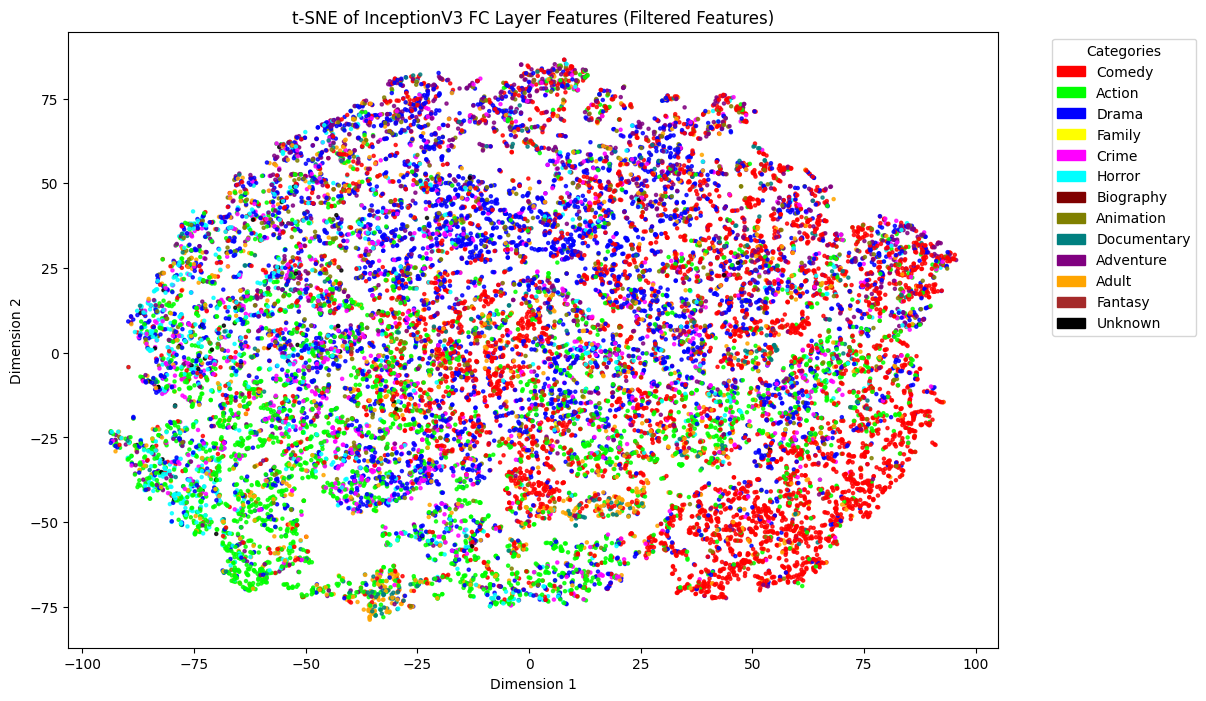

In [ ]:
# Additional cell to filter and visualize All features
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE

# Assuming train_features and train_labels are your feature and label tensors
features_np = train_features.numpy()
labels_np = train_labels.numpy()

# Assuming genre_to_index has been previously defined
# Reverse the genre_to_index dictionary to map indices to genre names
index_to_genre = {idx: genre for genre, idx in genre_to_index.items()}

# Define genres to include in the filtered t-SNE
genres_to_include = ['Comedy', 'Action', 'Drama', 'Family', 'Crime', 'Horror', 'Biography', 'Animation', 'Documentary', 'Adventure', 'Adult', 'Fantasy', 'Unknown']

# Get indices of the genres to include
indices_to_include = [genre_to_index[genre] for genre in genres_to_include]

# Filter the features and labels for the selected genres
filtered_features = features_np[np.isin(labels_np, indices_to_include)]
filtered_labels = labels_np[np.isin(labels_np, indices_to_include)]

# Map the filtered labels to 0 and 1 for t-SNE visualization
filtered_labels_mapped = np.array([indices_to_include.index(label) for label in filtered_labels])

# Perform t-SNE on the filtered data
tsne_filtered = TSNE(n_components=2, random_state=42)
features_2d_filtered = tsne_filtered.fit_transform(filtered_features)

# Define a colormap with two distinct colors
filtered_colors = [
    '#FF0000',  # Red
    '#00FF00',  # Green
    '#0000FF',  # Blue
    '#FFFF00',  # Yellow
    '#FF00FF',  # Magenta
    '#00FFFF',  # Cyan
    '#800000',  # Maroon
    '#808000',  # Olive
    '#008080',  # Teal
    '#800080',  # Purple
    '#FFA500',  # Orange
    '#A52A2A',  # Brown
    '#000000'   # Black
]  # Red for Comedy, Blue for Action
filtered_cmap = ListedColormap(filtered_colors)

# Plot the 2D features for Comedy vs. Action
plt.figure(figsize=(12, 8))
scatter_filtered = plt.scatter(features_2d_filtered[:, 0], features_2d_filtered[:, 1],
                               c=filtered_labels_mapped, cmap=filtered_cmap, alpha=0.8, s=5)

# Create a legend for the filtered categories
filtered_handles = [mpatches.Patch(color=filtered_colors[i], label=genres_to_include[i]) for i in range(len(genres_to_include))]
plt.legend(handles=filtered_handles, title="Categories", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('t-SNE of InceptionV3 FC Layer Features (Filtered Features)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Save the filtered plot as a high-resolution image
plt.savefig('tsne_final.png', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
import shutil
shutil.copy('tsne_final.png', '/content/drive/MyDrive/tsne_visualization13dim.png')

'/content/drive/MyDrive/tsne_visualization13dim.png'

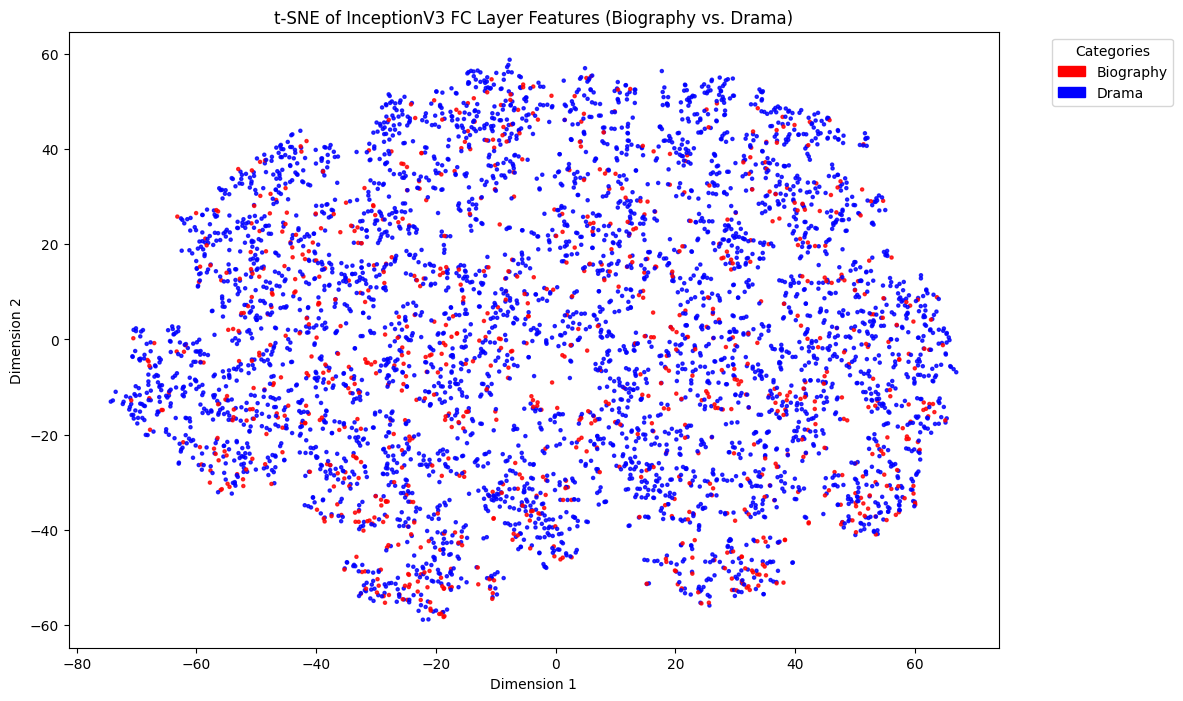

In [ ]:
# Additional cell to filter and visualize Crime vs. Drama

# Define genres to include in the filtered t-SNE
genres_to_include = ['Biography', 'Drama']

# Get indices of the genres to include
indices_to_include = [genre_to_index[genre] for genre in genres_to_include]

# Filter the features and labels for the selected genres
filtered_features = features_np[np.isin(labels_np, indices_to_include)]
filtered_labels = labels_np[np.isin(labels_np, indices_to_include)]

# Map the filtered labels to 0 and 1 for t-SNE visualization
filtered_labels_mapped = np.array([indices_to_include.index(label) for label in filtered_labels])

# Perform t-SNE on the filtered data
tsne_filtered = TSNE(n_components=2, random_state=42)
features_2d_filtered = tsne_filtered.fit_transform(filtered_features)

# Define a colormap with two distinct colors
filtered_colors = ['#FF0000', '#0000FF']  # Red for Comedy, Blue for Action
filtered_cmap = ListedColormap(filtered_colors)

# Plot the 2D features for Comedy vs. Action
plt.figure(figsize=(12, 8))
scatter_filtered = plt.scatter(features_2d_filtered[:, 0], features_2d_filtered[:, 1],
                               c=filtered_labels_mapped, cmap=filtered_cmap, alpha=0.8, s=5)

# Create a legend for the filtered categories
filtered_handles = [mpatches.Patch(color=filtered_colors[i], label=genres_to_include[i]) for i in range(len(genres_to_include))]
plt.legend(handles=filtered_handles, title="Categories", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('t-SNE of InceptionV3 FC Layer Features (Biography vs. Drama)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')

# Save the filtered plot as a high-resolution image
plt.savefig('tsne_crime_vs_drama.png', dpi=300, bbox_inches='tight')

plt.show()


In [ ]:
shutil.copy('tsne_crime_vs_drama.png', '/content/drive/MyDrive/tsne_biography_vs_drama.png')

'/content/drive/MyDrive/tsne_biography_vs_drama.png'